In [172]:
#Importing the important packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from IPython.display import Image

In [173]:
#Importing the important csv files in pandas ratings
df=pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [174]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [175]:
ratings=df.pivot(index='userId', columns='movieId', values='rating')

In [176]:
#Removing all the Nans from the ratings and changing it to 0's
ratings=ratings.fillna(0).values


In [177]:
##Defing the train and split for traiing and validation. 
'''
Parameters of nonZeros: Means this only takes if the user has rated over that particular value. 
              SizeRate: the randomised size of ratings for validation 
'''
def train_test_split(ratings, nonZeros, sizeRate):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() 
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=nonZeros:
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=sizeRate, 
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [178]:
##Defining our distance functions
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)

In [179]:
##Gradient gradient descent for The lower rank matrices
#P is the user matrix, Q is the item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [180]:
# Hyper parameter tuning
'''This was used for hyperparameter tuning to get the best parameters for the nZeros and sizes'''
def hyperParamTuning():
    hyper_param = {}
    for nzero in range(20,50,5):
        for sizes in range(10,30,5):
            train, val = train_test_split(ratings, nzero, sizes)
            lmbda = 0.4 # Regularization parameter
            k = 2 
            m, n = train.shape  # Number of users and items
            n_epochs = 100  # Number of epochs
            alpha=0.01  # Learning rate

            P = 3 * np.random.rand(k,m) # Latent user feature matrix
            Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
            train_errors = []
            val_errors = []

            #Only consider items with ratings 
            users,items = train.nonzero()      
            for epoch in range(n_epochs):
                for u, i in zip(users,items):
                    e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
                    P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
                    Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
                
                pred= prediction(P,Q)
                train_rmse = rmse(pred,train)
                val_rmse = rmse(pred,val) 
                
                train_errors.append(train_rmse)
                val_errors.append(val_rmse)
            hyper_param[(nzero, sizes)] = [train_errors, val_errors, ]
            print(f"For HyperParams {(nzero, sizes)}, rmse_train = {train_rmse}, rmse_test = {val_rmse}")
    return(hyper_param)

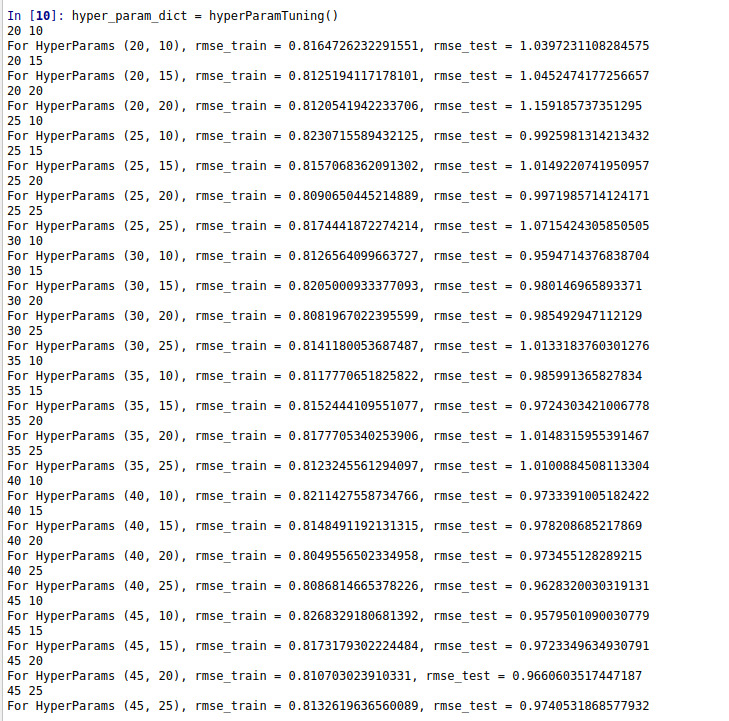

In [181]:
Image(filename='Jupyter.jpeg')

'''Running the above code gives the following Image 
(Lab was used and Jupyter wasnt working so had to use spyder on the Lab computer)
Attach image HERE!!!!!'''

hyper_param_dict = hyperParamTuning()

In [182]:
def prediction_final():
    ##Got the best parameters and have been used in this. 
    train, val = train_test_split(ratings, 35, 15)
    lmbda = 1e-3 # Regularization parameter
    k = 2 
    m, n = train.shape  # Number of users and items
    n_epochs = 100  # Number of epochs
    alpha=0.01  # Learning rate

    P = 3 * np.random.rand(k,m) # Latent user feature matrix
    Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

    
    #Only consider items with ratings 
    users,items = train.nonzero()      
    for epoch in range(n_epochs):
        for u, i in zip(users,items):
            e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
            P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
            Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
        print(f"Epoch number: {epoch}, training rmse: {rmse(prediction(P,Q),train)}, Testing RMSE: {rmse(prediction(P,Q),val)}, MAE: {mae(prediction(P,Q),val)}")

    return(prediction(P,Q))

In [183]:
pred = prediction_final()

Epoch number: 0, training rmse: 1.2526941976825214, Testing RMSE: 1.306175151619237, MAE: 1.0406611162849444
Epoch number: 1, training rmse: 1.0901031219290898, Testing RMSE: 1.1263421983811055, MAE: 0.8673493725532564
Epoch number: 2, training rmse: 1.0296553959946753, Testing RMSE: 1.072162056441849, MAE: 0.8199486197382904
Epoch number: 3, training rmse: 0.9939790556340792, Testing RMSE: 1.044058571886403, MAE: 0.795350987589522
Epoch number: 4, training rmse: 0.9698473949454293, Testing RMSE: 1.0268639415140839, MAE: 0.7806999431415692
Epoch number: 5, training rmse: 0.9522273347435084, Testing RMSE: 1.0152881911314668, MAE: 0.7709461490901142
Epoch number: 6, training rmse: 0.9387025968715648, Testing RMSE: 1.0070125366885718, MAE: 0.7639091860074454
Epoch number: 7, training rmse: 0.9279414866496335, Testing RMSE: 1.0008546045751276, MAE: 0.7586229078673846
Epoch number: 8, training rmse: 0.9191399513547435, Testing RMSE: 0.9961421803541257, MAE: 0.7545297766927758
Epoch number: 

Epoch number: 75, training rmse: 0.8220142971289417, Testing RMSE: 0.9845499403223167, MAE: 0.7416254742565529
Epoch number: 76, training rmse: 0.8215879420606351, Testing RMSE: 0.9845490602200456, MAE: 0.7415663185838436
Epoch number: 77, training rmse: 0.8211674701148818, Testing RMSE: 0.9845449198115473, MAE: 0.7415088120331856
Epoch number: 78, training rmse: 0.8207526690615419, Testing RMSE: 0.9845377029085541, MAE: 0.7414491542250956
Epoch number: 79, training rmse: 0.8203433375842377, Testing RMSE: 0.9845275907947049, MAE: 0.7413840691291701
Epoch number: 80, training rmse: 0.8199392849643367, Testing RMSE: 0.9845147617025745, MAE: 0.7413141458197126
Epoch number: 81, training rmse: 0.8195403307423987, Testing RMSE: 0.9844993903744905, MAE: 0.7412409741048324
Epoch number: 82, training rmse: 0.8191463043581648, Testing RMSE: 0.9844816477050116, MAE: 0.7411640008518907
Epoch number: 83, training rmse: 0.81875704477068, Testing RMSE: 0.9844617004606259, MAE: 0.7410863184698946
Epo

In [71]:
def get_movie_name(index):
    return(movies['title'].values[index])

In [128]:
##GETTING THE TOP 5 MOVIES FOR A PARTICULAR USER:
def getLikedMovies(userID , ratings = ratings, prediction = pred, movies = movies):
    user = ratings[userID]
    movie_ids = np.nonzero(user)
    list_of_movies = []
    list_of_alrady_liked = []
    ratingAbove4 = []
    for i in movie_ids[0]:
        list_of_movies.append(get_movie_name(i))
        list_of_alrady_liked.append(i)
        if user[i] >4.5:
            ratingAbove4.append(get_movie_name(i))
    
    list_user_pred = pred[userID]
    movie_dict = {}
    for i in range(len(list_user_pred)):
        if list_user_pred[i] > 4.5:
            movie_dict[list_user_pred[i]] = (i, get_movie_name(i))
    ##Getting the top 5 movies:
    
    top_movies = []
    for j in sorted(movie_dict.keys())[::-1]:
        if movie_dict[j][0] not in list_of_alrady_liked:
            top_movies.append(movie_dict[j])
    
    
    if len(ratingAbove4) >=11:
        return(ratingAbove4[:10], top_movies[:5]) 
    else:
        return(ratingAbove4, top_movies[:5])
        
    

In [132]:
getLikedMovies(9)

(['13 Going on 30 (2004)',
  'Immigrant, The (1917)',
  'Paparazzi (2004)',
  'Madagascar (2005)',
  'Shortbus (2006)',
  'Catch a Fire (2006)',
  'Blood Creek (a.k.a. Town Creek) (2009)',
  'A-Team, The (2010)',
  'Heartbeats (Les amours imaginaires) (2010)',
  'War Horse (2011)'],
 [(5791, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
  (4122, 'Android (1982)'),
  (8223, 'Coffee Town (2013)'),
  (5444, "Teacher's Pet (1958)"),
  (2593, 'Hustler, The (1961)')])